# Propuesta de arquitectura para implementación de compra a crédito en sucursales de Farmacias Guadalajara

## Proceso Operativo
Se requiere un proceso en el cual Prixz pueda comprar en cualquier sucursal de Farmacias Guadalajara y que a los repartidores asignados se les entregue el pedido generado en las sucursales correspientes sin necesidad de que el repartidor o el empleado de la sucursal tengan que utilizar medios análogos que retrasen el proceso de compra

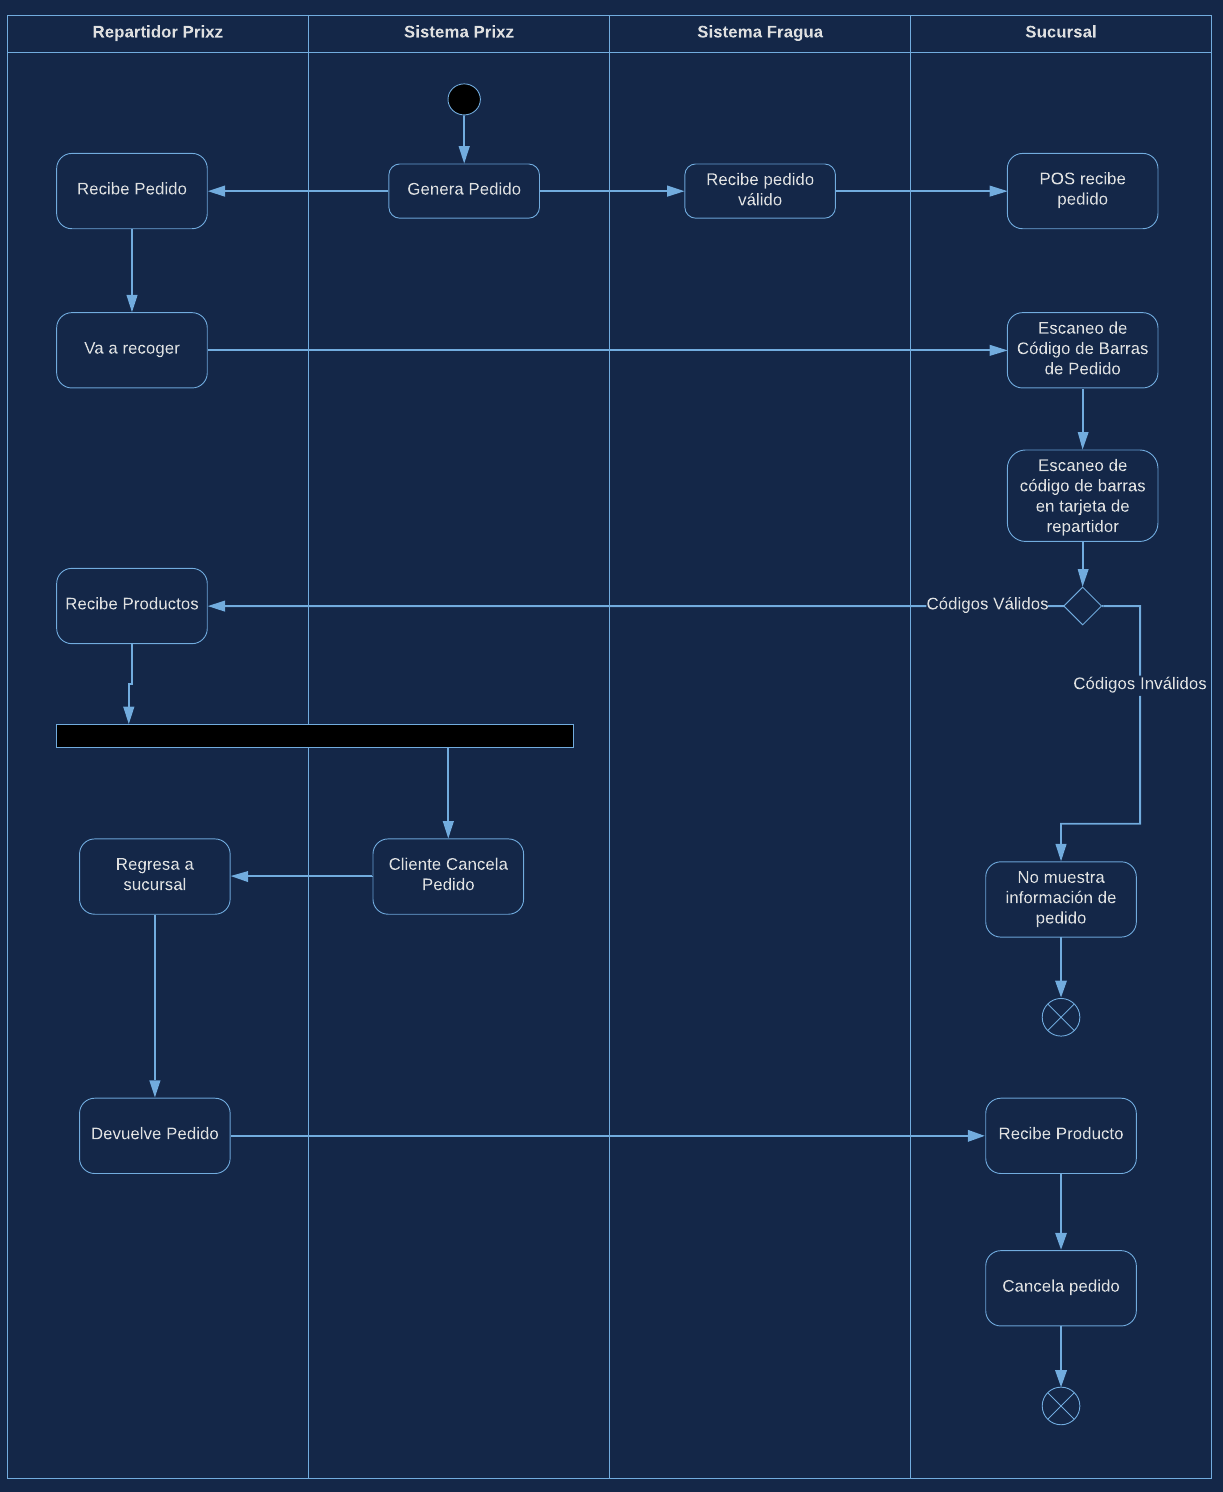

In [1]:
from IPython.display import Image
Image(filename='assets/diagram.png',width=800, height=400)

## Generación de Códigos
Durante el proceso de requiere verificar la identidad del repartidor, así como la no-duplicidad del pedido. Por lo que el pedido irá acompañado de un identificador numérico de 12 dígitos representado gráficamente con un código de barras. Así mismo el repartidor contará con una tarjeta, física o digital (En el teléfono) con otro identificador numérico de 12 dígitos representado, del mismo modo, por un código de barras.

Tanto el identificador numérico del repartidor, como el identificador del pedido estarán encriptados de manera tal que la POS pueda comprobar su validez utilizando un algoritmo de encriptación definido.

Al servicio proporicionado por fragua se enviarán ambos códigos para ser validados al momento de consultar el pedido, para dicho fin se proporcionarán las llaves y métodos de encripción correspondientes a cada código como se describe a continuación:

## Código de pedido
El código de pedido estará dividido en 2 grupos. Los primeros 4 caracteres son el Grupo 1 y los 7 restantes el Grupo2. El primero grupo contendrá 2 datos: El número de día del año correspondiente al día en el que el pedido fue **generado** y un dígito de control como se muestra a continuación

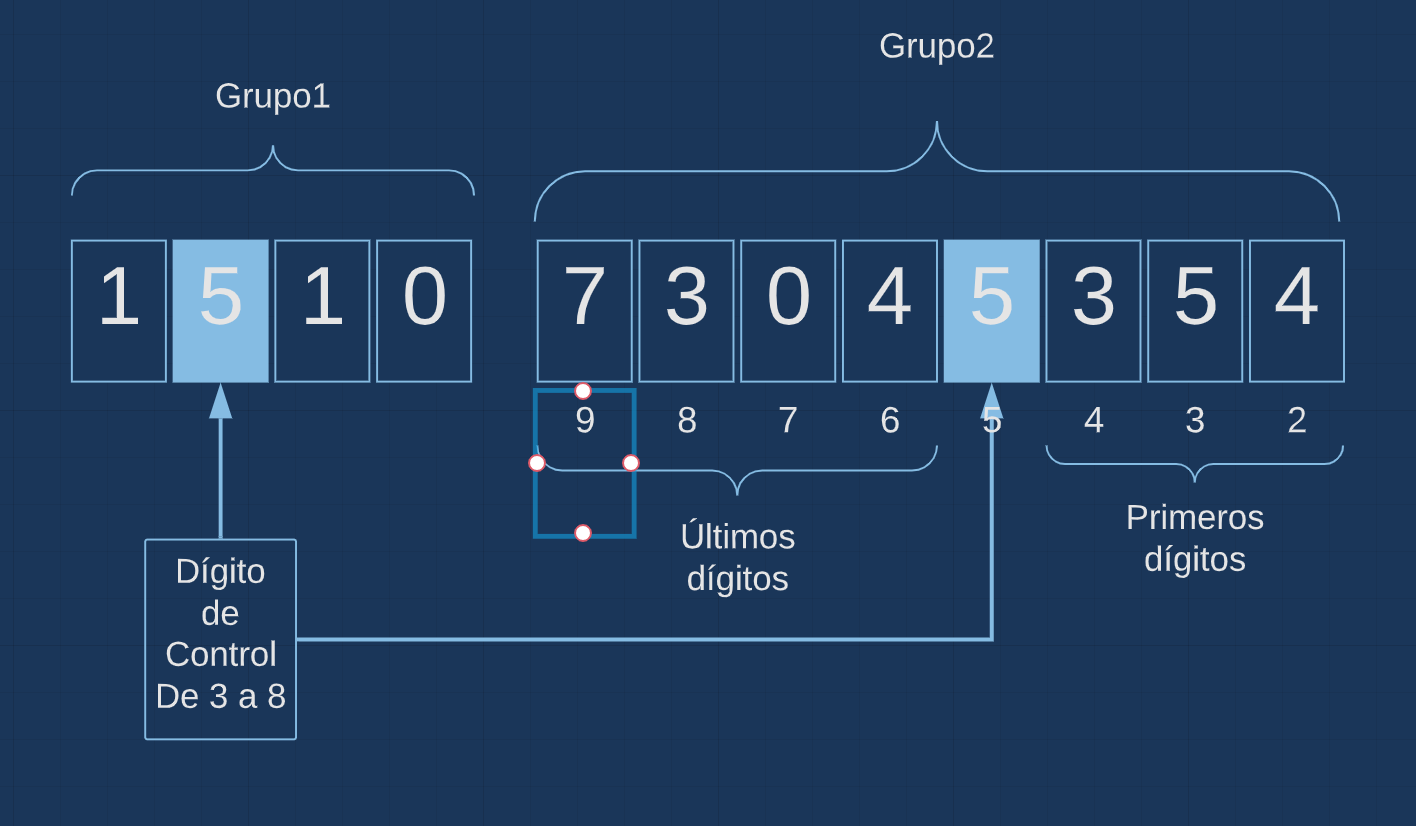

In [2]:
from IPython.display import Image
Image(filename='assets/encryption.png',width=800, height=400)

Como se puede ver en la imagen, el dígito de control será un *número aleatorio entre 3 y 8* que indicará la posición bloqueada del segundo grupo, que contendrá el mismo dígito. En el caso de la imagen, el dígito de control es el *5*, por lo que se toma la posición 5 de derecha a izquierda, empezando por el 2.

Lo anterior provoca que el grupo 2 se encuentre separado en 2 secciones. La sección de la izquierda contendrán los últimos dígitos del código generado, y la de la derecha contendrá los primeros.

El código generado utilizará el siguiente algoritmo:

Fecha actual en milisegundos dese [epoch](https://en.wikipedia.org/wiki/Unix_time) es un dígito de 13 caracteres. De dicho dígito se descartarán los primeros 4 y los últimos 2 dígitos, quedando así un identificador de 7 dígitos que se distribuirá en las 2 secciones en las que se dividió el grupo 2.

El siguiente código muestra la generación de un código único utilizando el momento actual:

In [3]:
import datetime
from random import seed
from random import randint
#Dígito de Control
control_digit=randint(3,8)

#Generación de primer grupo
def firstGroup(cd):
    #Fecha actual exacta
    now=datetime.datetime.now()
    #Primer día de éste año
    newyear=datetime.datetime(now.year,1,1)
    #Días transcurridos desde primer día del año más uno (Día del año)
    nday=str((now-newyear).days+1)
    print("Día del año:",nday)
    #Se convierte a lista
    r=list(nday)
    #Se inserta el código de control en la segunda posición
    r.insert(1,cd)
    #La lista se convierte a cadenas de texto y se devuelven los datos
    return "".join(str(i) for i in r)

#Generación del segundo grupo
def secondGroup(cd):
    code=list(str(round(datetime.datetime.now().timestamp()*1000)))[4:11]
    print("Código basado en fecha actual:","".join(str(j) for j in code))
    full=code[-(9-cd):]+[cd]+code[:-(9-cd)]
    return "".join(str(k) for k in full)

print("Dígito Verificador:",control_digit)
firstGroup(control_digit)+secondGroup(control_digit)

Dígito Verificador: 5
Día del año: 142
Código basado en fecha actual: 1091060


'154210605109'

Un código generado se puede validar extrayendo el día del año y el código basado en fecha y revisar si corresponden

## Proceso de Conciliación

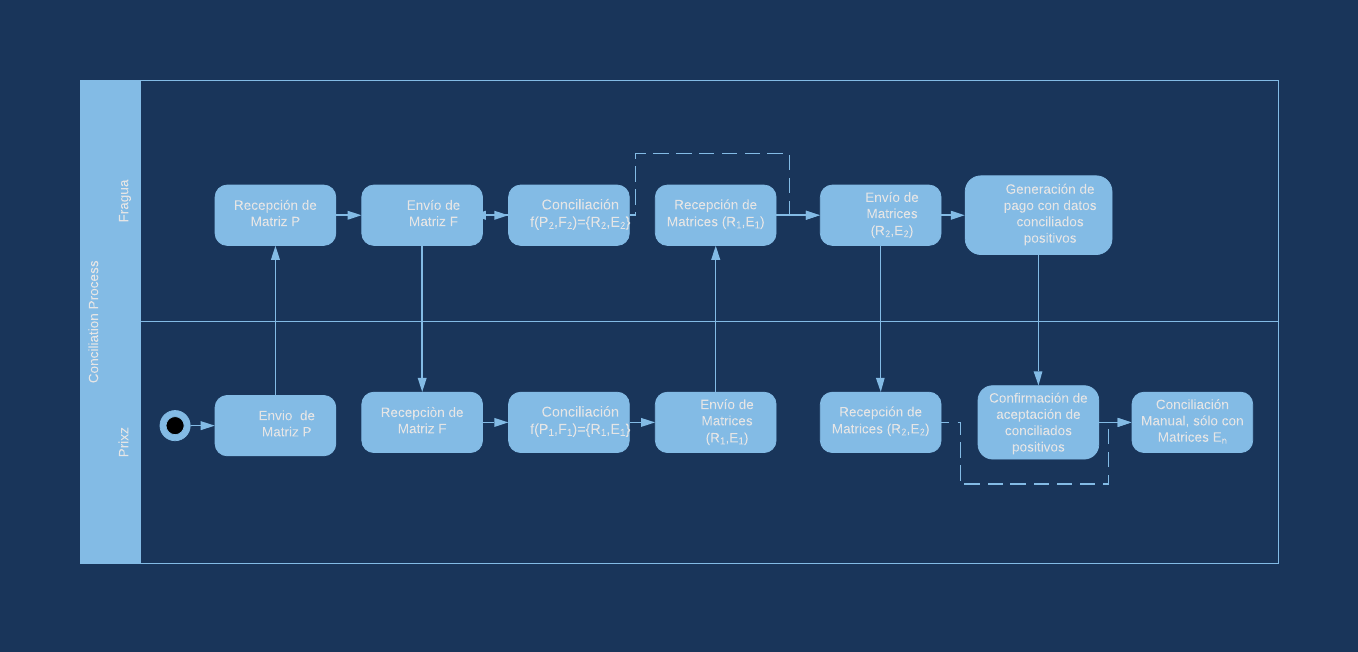

In [4]:
from IPython.display import Image
Image(filename='assets/conciliation_activity.png',width=800, height=400)

El proceso de conciliación a ejecutar constará de:
- Un Horario definido
- Dos intercambios de archivos
- Una algoritmo de validación
- Una conciliación residual manual

### Horario
Se ejecutará un proceso conjunto para conciliar las órdenes que se ejecutará utilizando el mismo periodo de corte definido por el negocio. Si el corte se define cada semana, el proceso se ejecutará cada semana.

Dicho proceso deberá ejecutarse en un rango de horario no habil, es decir que no existan órdenes procesadas durante el momento de la ejecución del proceso; 4am por ejemplo.

### Primer intercambio de archivos
Cada sistema, el de Prixz y y el de Fragua, ya tendria su propia matriz de operaciones almacenada en el momento de ejecutar la conciliación. Prixz enviará su lista de operaciones a Fragua y del mismo modo, Fragua enviará a Prixz la suya. Dicho proceso se ejecutará utilizando un endpoint tipo REST, enviando las órdenes paginadas por grupos de 10000, variando dicha cantidad durante futuras optimiazaciones.

### Algoritmo de validación

A la matriz de operaciones enviada por Prixz le llamaremos  __P<sub>1</sub>__ y a la enviada por Fragua __P<sub>2</sub>__. Estas matrices serán procesadas, comparándo unívocamente cada operación contenida en cada matriz.

$$x \in P, y \in F ;\left\lvert\big(\sum_{i=1}^{n}{x_i} \big) - \big(\sum_{j=1}^{m}{y_j} \big)\right\rvert = 0$$

Adjuntos a este documento podemos encontrar los ejemplos de las matrices

In [5]:
import pandas as pd
from IPython.display import display, HTML
P = pd.read_csv("assets/P.csv")
F = pd.read_csv("assets/F.csv")

Matriz _P_ de pedidos generada por __Prixz__

In [6]:
display(P)

,id,date,ammount
0,R1,10/10/2020,120
1,R2,10/10/2020,160
2,R3,11/10/2020,80
3,R4,11/10/2020,220
4,R5,12/10/2020,180
5,R6,12/10/2020,210


Matriz _F_ de pedidos generada por __Fragua__

In [7]:
display(F)

,id,date,ammount
0,R1,10/10/2020,120
1,R2,10/10/2020,160
2,R3,11/10/2020,90
3,R4,11/10/2020,220
4,R5,12/10/2020,180
5,R6,12/10/2020,180


In [8]:
challenge = abs(P['ammount'].sum() - F['ammount'].sum()) == 0
if challenge:
    display('Las matrices están conciliadas')
else:
    display('Las matrices son distintas, se debe continuar con el proceso de conciliación')

'Las matrices son distintas, se debe continuar con el proceso de conciliación'

Como se puede notar en el ejemplo, el valor absoluto de la resta de ambas matrices es diferente de 0, lo que significa que hay que proceder a conciliar las matrices.

El proceso de validación  se puede expresar con la siguiente fórmula:

$$\begin{eqnarray}
f(P_{n},F_{n}) = \big\{R_{n},E_{n}\big\}
\end{eqnarray}$$

Siendo _x_ el monto de las operaciones en __P__.
Siendo _P_ la matriz generada por Prixz.
Siendo _y_ el monto de las operaciones en __F__.
Y siendo _F_ la matriz generada por Fragua.

La matriz se dará por conciliada cuando __el valor absoluto de la resta de los montos de ambas matrices sea igual a 0__.

Generando así 4 matrices, 2 por cada partner: Una de operaciones que __sí coinciden__, a la cual llamaremos __R<sub>n<sub>__, y otra de operaciones que, o __no coinciden__ o __no existen en alguna de las 2 matrices__, a la cual llamaremos __E<sub>n<sub>__. 

In [9]:
#Verificamos que las matrices sean iguales en dimensiones, si son distintas corremos el proceso
if P.shape == F.shape and abs(P['ammount'].sum() - F['ammount'].sum()) == 0:
    display('Las matrices son iguales, puede procesarse el pago')
else:
    R = pd.DataFrame(columns=['id','date','ammount'])
    E = pd.DataFrame(columns=['id','P.date','F.date','P.ammount','F.ammount'])
    for i in range(max(P.shape[0],F.shape[0])):
        if P.iloc[i]['id'] == F.iloc[i]['id']:
            if P.iloc[i]['ammount'] == F.iloc[i]['ammount']:
                R = R.append(P.iloc[i])
            else:
                E = E.append({'id':P.iloc[i]['id'], 
                              'P.date': P.iloc[i]['date'], 
                              'F.date': F.iloc[i]['date'], 
                              'P.ammount': P.iloc[i]['ammount'], 
                              'F.ammount': F.iloc[i]['ammount']
                             }, ignore_index=True)

Al ejecutar el proceso, el resultado serán la Matriz R y la Matriz E en cada uno de los sistemas:
#### La matriz R

In [10]:
display(R)

,id,date,ammount
0,R1,10/10/2020,120
1,R2,10/10/2020,160
3,R4,11/10/2020,220
4,R5,12/10/2020,180


#### La matriz E

In [11]:
display(E)

,id,P.date,F.date,P.ammount,F.ammount
0,R3,11/10/2020,11/10/2020,80,90
1,R6,12/10/2020,12/10/2020,210,180


### Segundo intercambio de Archivos
Para el siguiente intercambio cada sistema enviará las matrices resultantes del mismo modo que envió las primeras, tipificadas así:

1. __R<sub>1</sub>__ Matriz de operaciones coincidentes generada por Prixz
1. __R<sub>2</sub>__ Matriz de operaciones coincidentes generada por Fragua
1. __E<sub>1</sub>__ Matriz de operaciones no-coincidentes generada por Prixz
1. __E<sub>2</sub>__ Matriz de operaciones no-coincidentes generada por Fragua

Cada sistema comparará las matrices _R_ del mismo modo que en el primer intercambio, en caso de ser unívocas, es decir que el valor absoluto de la resta de sus montos sean igual a 0, se darán por conciliadas y Fragua iniciará el proceso de pago.

La matriz de errores no es necesario compararla computacionalmente ya que se enviará por correo a las personas estipuladas dentro de cada equipo para que las revisen en equipo de manera manual para su validación, iniciando el proceso de pago cuando queden validadas.

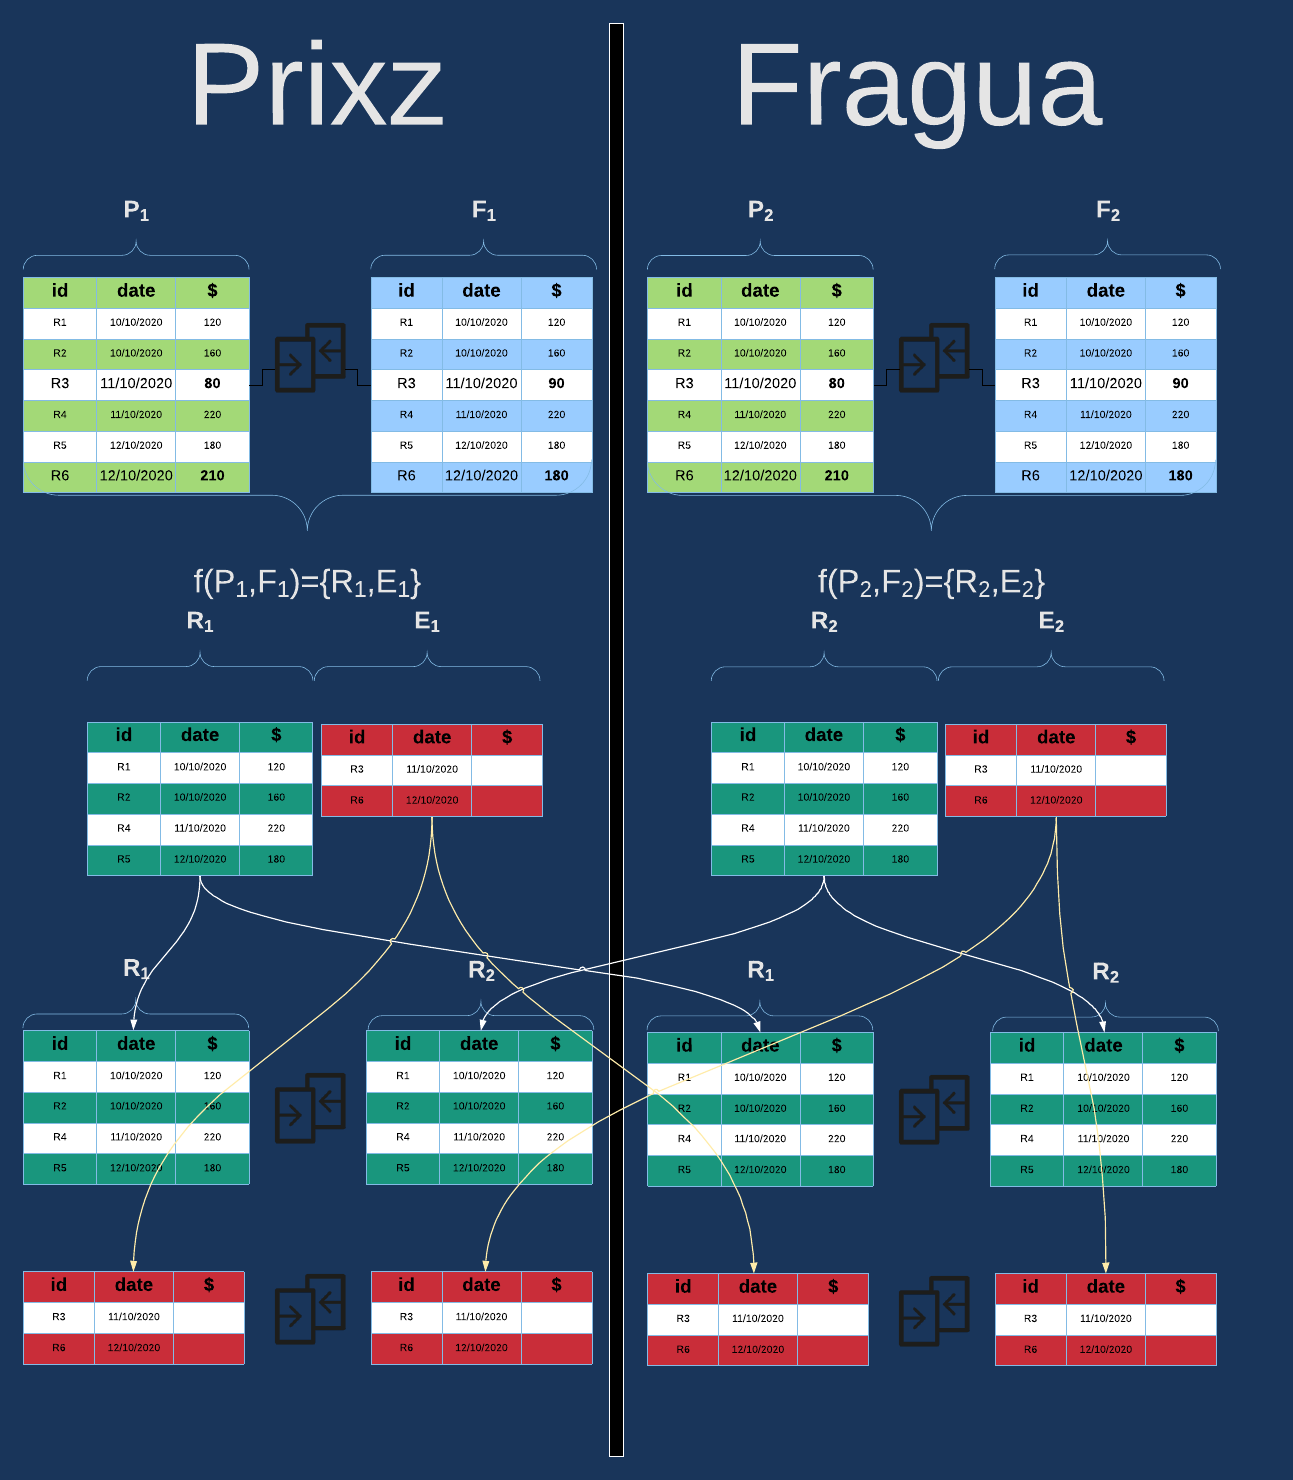

In [12]:
from IPython.display import Image
Image(filename='assets/conciliation_abstract.png',width=800, height=400)